



# Facial Emotion Recognition using Deep CNN with Transfer Learning: A Cross-Cultural Application.





This Jupyter Notebook contains the code behind my Dissertation Project. As per my Ethics plan, I have used my Google Drive to save the datasets, and as per my Project Plan, I have utilised Colab's GPU to tranform data and build the prediction model.

For marking purposes I have altered the .ipynb to run locally with the datasets included in the same zipped folder. 



# **1. Load all the libraries**

In [ ]:
#load up all the necessary libraries, please make sure all the libraries load/are downloaded if checking/rerunning code
import csv
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.stats import trim_mean

# **2. Create Dataset() and Labels() classes**

 Due to having to transform multiple datasets, the Dataset() and Labels() classes were created to standardise the data and cut out code repetitions.


In [ ]:
class Labels():
  def __init__(self):
    self.labels = []

  #this function parses through the labels in a saved csv. Please note the expressions (currently on a 1-7 scale), are converted to 0-6 scale (as zero-based indexes are necessary for tensorflow).
  def save_labels(self, path):
        with open(path, newline='') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader)

            for row in reader:
                label_entry = {
                    'image_id': row[0].strip(),
                    'exp': int(row[1].strip()) - 1
                }
                if len(row) >= 3 and row[2].strip() != '':
                    label_entry['aro'] = float(row[2].strip())
                self.labels.append(label_entry)


  #this function takes the previously created list of labels and converts them to np.arrays (necessary for tensorflow)
  def get_labels(self):
        image_ids = [entry['image_id'] for entry in self.labels]
        exp_labels = [entry['exp'] for entry in self.labels]

        # Check if all entries have aro
        if all('aro' in entry for entry in self.labels):
            aro_labels = [entry['aro'] for entry in self.labels]
            return (
                np.array(image_ids),
                np.array(exp_labels, dtype=np.int32),
                np.array(aro_labels, dtype=np.float32),
            )
        #if not, then only the image ids and expression labels get saved
        else:
            return (
                np.array(image_ids),
                np.array(exp_labels, dtype=np.int32)
            )

class Dataset:

    def __init__(self):
        self.images = []

    #function that resized the images to a square format
    def toSquare(self, image, required_size=224):
        current_size = image.shape[:2]
        ratio = float(required_size) / max(current_size)

        new_width = int(current_size[1] * ratio)
        new_height = int(current_size[0] * ratio)
        new_size = (new_height, new_width)

        resized_image = cv2.resize(image, (new_size[1], new_size[0]))

        height_extra = required_size - new_size[0]
        top = height_extra - (height_extra // 2)
        bottom = height_extra - (height_extra // 2)

        width_extra = required_size - new_size[1]
        left = width_extra // 2
        right = width_extra - (width_extra // 2)
        color = [0, 0, 0]

        new_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right,
                                       cv2.BORDER_CONSTANT, value=color)
        return new_image

    #function that reshapes the images if they are not square already and standardises the pixel values
    def save_and_rescale_images(self, path, image_ids, notSquare=False):
        for entry in image_ids:
            image_filename = entry + '.jpg'
            image_path = os.path.join(path, image_filename)
            try:
                image = Image.open(image_path).convert('RGB')
            except:
                image_filename = entry + '.bmp'
                image_path = os.path.join(path, image_filename)
                image = Image.open(image_path).convert('RGB')

            image = np.array(image)

            if notSquare == True:
                image = self.toSquare(image, required_size=224)
            else:
                image = cv2.resize(image, (224, 224))

            image = image.astype('float32') / 255.0
            self.images.append(image)

        return np.array(self.images)





# **3. Process The Datasets**


This section of code processes and assigns data from AffectNet, FER13, DISFA, FAMED, WSEFEP and PEDFE. The Labels and Images are then saved as npy files to avoid running this function repeatedly (it is costly). 

If the npy files are needed for code testing, please note they are loaded from the saved .npy files later in the code. This helps to avoid running this section unless absolutely necessary. 

In [ ]:
#locations of the datasets and annotations
annotations_train = 'AffectNet/affnet_annot_train.csv'
images_train = 'AffectNet/affnet_images_train'
annotations_val = 'AffectNet/affnet_annot_val.csv'
images_val = 'AffectNet/affnet_images_val'

affectNet_labels_train = Labels()
affNet_labels_train = affectNet_labels_train.save_labels(annotations_train)

affectNet_labels_val = Labels()
affNet_labels_val = affectNet_labels_val.save_labels(annotations_val)

image_ids_train, affNet_exp_labels_train, affNet_aro_labels_train= affectNet_labels_train.get_labels()
image_ids_val, affNet_exp_labels_val, affNet_aro_labels_val= affectNet_labels_val.get_labels()

#processing images
affectNet_images_train = Dataset()
affNet_images_train = affectNet_images_train.save_and_rescale_images(images_train, affNet_labels_train, notSquare=False)

affectNet_images_val = Dataset()
affNet_images_val= affectNet_images_val.save_and_rescale_images(images_val, affNet_labels_val, notSquare=False)

# saving the arrays locally on Google Drive
np.save('AffectNet/affnet_images_train.npy', affNet_images_train)
np.save('AffectNet/affnet_exp_train.npy', affNet_exp_labels_train)
np.save('AffectNet/affnet_aro_train.npy', affNet_aro_labels_train)

np.save('AffectNet/affnet_images_val.npy', affNet_images_val)
np.save('AffectNet/affnet_exp_val.npy', affNet_exp_labels_val)
np.save('AffectNet/affnet_aro_val.npy', affNet_aro_labels_val)




Image {'image_id': '40', 'exp': 1, 'aro': -0.269034, 'val': -0.786925} has been assigned successfully
Image {'image_id': '48', 'exp': 1, 'aro': -0.227449, 'val': -0.94367} has been assigned successfully
Image {'image_id': '52', 'exp': 5, 'aro': 0.873016, 'val': -0.420635} has been assigned successfully
Image {'image_id': '79', 'exp': 4, 'aro': 0.474255, 'val': -0.813008} has been assigned successfully
Image {'image_id': '92', 'exp': 0, 'aro': -0.07259, 'val': 0.880759} has been assigned successfully
Image {'image_id': '131', 'exp': 6, 'aro': 0.672667, 'val': -0.546845} has been assigned successfully
Image {'image_id': '183', 'exp': 2, 'aro': 0.637847, 'val': 0.281479} has been assigned successfully
Image {'image_id': '193', 'exp': 0, 'aro': 0.515873, 'val': 0.730159} has been assigned successfully
Image {'image_id': '208', 'exp': 5, 'aro': 0.447289, 'val': -0.715662} has been assigned successfully
Image {'image_id': '212', 'exp': 6, 'aro': 0.483933, 'val': -0.411343} has been assigned 

KeyboardInterrupt: 

DISFA and WSEFEP datasets contains emotion intensity measure, which is saved for later model accuracy assessment, FAMED and PEDFE do not, so only expression labels are saved.

In [ ]:
disfa_images_path = 'DISFA/disfa_images'
disfa_annotations = 'DISFA/disfa_annot.csv'

disfa_labels = Labels()
disfa_labels.save_labels(disfa_annotations)
disfa_image_ids, disfa_exp_labels, disfa_aro_labels = disfa_labels.get_labels()

disfa_images = Dataset()
disfa_images_np = disfa_images.save_and_rescale_images(disfa_images_path, disfa_image_ids, notSquare=True)
np.save('DISFA/disfa_images.npy', disfa_images_np)
np.save('DISFA/disfa_exp_labels.npy', disfa_exp_labels)
np.save('DISFA/disfa_aro_labels.npy', disfa_aro_labels)


In [9]:
import os

file_path = 'FER13/fer13_exp_train.npy' 

if os.path.exists(file_path):
    print("File exists!")
else:
    print("File not found.")

File exists!


In [ ]:
famed_images_path = 'FAMED/famed_images'
famed_annotations = 'FAMED/famed_annot.csv'

famed_labels = Labels()
famed_labels.save_labels(famed_annotations)
famed_image_ids, famed_exp_labels = famed_labels.get_labels()

famed_images = Dataset()
famed_images_np = famed_images.save_and_rescale_images(famed_images_path, famed_image_ids, notSquare=True)
np.save('FAMED/famed_images.npy', famed_images_np)
np.save('FAMED/famed_exp_labels.npy', famed_exp_labels)

In [ ]:
pedfe_images_path = 'PEDFE/pedfe_images'
pedfe_annotations = 'PEDFE/pedfe_annot.csv'

pedfe_labels = Labels()
pedfe_labels.save_labels(pedfe_annotations)
pedfe_image_ids, pedfe_exp_labels = pedfe_labels.get_labels()

pedfe_images = Dataset()
pedfe_images_np = pedfe_images.save_and_rescale_images(pedfe_images_path, pedfe_image_ids, notSquare=False)
np.save('PEDFE/pedfe_images.npy', pedfe_images_np)
np.save('PEDFE/pedfe_exp_labels.npy', pedfe_exp_labels)

In [ ]:
wsefep_images_path = 'WSEFEP/wsefep_images'
wsefep_annotations = 'WSEFEP/wsefep_annot.csv'

wsefep_labels = Labels()
wsefep_labels.save_labels(wsefep_annotations)
wsefep_image_ids, wsefep_exp_labels, wsefep_aro_labels = wsefep_labels.get_labels()

wsefep_images = Dataset()
wsefep_images_np = wsefep_images.save_and_rescale_images(wsefep_images_path, wsefep_image_ids, notSquare=True)
np.save('WSEFEP/wsefep_images.npy', wsefep_images_np)
np.save('WSEFEP/wsefep_exp_labels.npy', wsefep_exp_labels)
np.save('WSEFEP/wsefep_aro_labels.npy', wsefep_aro_labels)

FER13 dataset was also pre-processed, using the same functions.

In [ ]:
fer_train_annot = 'FER13/fer13_annot_train.csv'
fer_train_images = 'FER13/fer13_images_train'

fer_val_annot = 'FER13/fer13_annot_val.csv'
fer_val_images = 'FER13/fer13_images_val'

fer_labels_train = Labels()
fer_labels_train.save_labels(fer_train_annot)
fer_image_ids_train, fer_exp_labels_train = fer_labels_train.get_labels()

fer_labels_val = Labels()
fer_labels_val.save_labels(fer_val_annot)
fer_image_ids_val, fer_exp_labels_val = fer_labels_val.get_labels()

fer_images_train = Dataset()
fer_train_images = fer_images_train.save_and_rescale_images(images_train, image_ids_train)

fer_images_val = Dataset()
fer_val_images= fer_images_val.save_and_rescale_images(images_val, image_ids_val)

np.save('FER13/fer13_images_train.npy', fer_train_images)
np.save('FER13/fer13_exp_train.npy', fer_exp_labels_train)
np.save('FER13/fer13_images_val.npy', fer_val_images)
np.save('FER13/fer13_exp_val.npy', fer_exp_labels_val)

Next the distibution of FER13 dataset was plotted to unsure an even distibution of images per class.

In [ ]:
#if the RAM exceeds the limit, uncomment the below to restore the local values
'''fer_val_images = 'FER13/fer13_images_val.npy'
fer_exp_labels_val = 'FER13/fer13_exp_val.npy'
fer_train_images = 'FER13/fer13_images_train.npy'
fer_exp_labels_train = 'FER13/fer13_exp_train.npy' '''

# decode the numeric values back to emotions
emotion_classes, counts = np.unique(fer_exp_labels_train, return_counts=True)

class_mapping = {
    0: "Happy",
    1: "Sad",
    2: "Surprise",
    3: "Fear",
    4: "Disgust",
    5: "Anger"
}

class_names = []
for c in emotion_classes:
    class_names.append(class_mapping[c])

# plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts, color="green")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As a result of visualising the distibution, the class imbalance is apparent. Thefore, a weighted loss function is neccessary to be applied.

In [ ]:
# calculate the weights and assign them to later allocate them into the FER13 model
class_weights = compute_class_weight(class_weight='balanced', classes=emotion_classes, y=fer_exp_labels_train)
class_weights_dict = {}
for i in range(len(class_weights)):
    class_weights_dict[i] = class_weights[i]

# **4. Load and customise the VGG16 FER13 model**

---



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


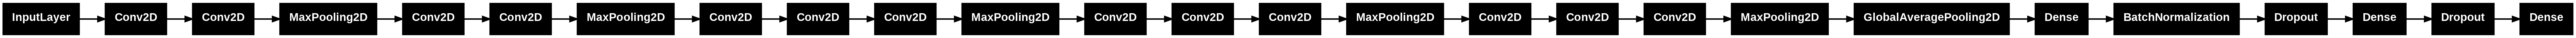

In [ ]:
input_tensor = Input(shape=(224, 224, 3))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)


for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True

#customising the final layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)

fer13_model = Model(inputs=input_tensor, outputs=output)

fer13_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
plot_model(
    fer13_model,
    to_file='FER13model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR'
)

In [ ]:
#adding early stopping and reducing learning rate when the learning slows down significantly based on the metric we are most interested in - val_accuracy
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
rlrp = ReduceLROnPlateau(
        monitor='val_accuracy',
        mode='max',
        factor=0.5,
        patience=2,
        verbose=1
    )

In [ ]:
#training the model for 30 epochs with the customised weights and incorporating early stopping and reducing learning rate
history = fer13_model.fit(
    fer_train_images, fer_exp_labels_train,
    validation_data=(fer_val_images, fer_exp_labels_val),
    epochs=30,
    batch_size=64,
    class_weight = class_weights_dict,
    callbacks = [early_stop, rlrp]
)

Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 149s 317ms/step - accuracy: 0.2389 - loss: 1.9647 - val_accuracy: 0.4772 - val_loss: 1.5903 - learning_rate: 1.0000e-05
Epoch 2/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 94s 252ms/step - accuracy: 0.4000 - loss: 1.4862 - val_accuracy: 0.4881 - val_loss: 1.2915 - learning_rate: 1.0000e-05
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 93s 252ms/step - accuracy: 0.4893 - loss: 1.3040 - val_accuracy: 0.5553 - val_loss: 1.1165 - learning_rate: 1.0000e-05
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 93s 252ms/step - accuracy: 0.5185 - loss: 1.1966 - val_accuracy: 0.5855 - val_loss: 1.0720 - learning_rate: 1.0000e-05
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 93s 252ms/step - accuracy: 0.5601 - loss: 1.0921 - val_accuracy: 0.5371 - val_loss: 1.2101 - learning_rate: 1.0000e-05
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 94s 252ms/step - accuracy: 0.5923 - loss: 0.9958 - val_accuracy: 0.6165 - val_loss: 0.9762 - learning_rate: 1.0000e-05
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 94s 2

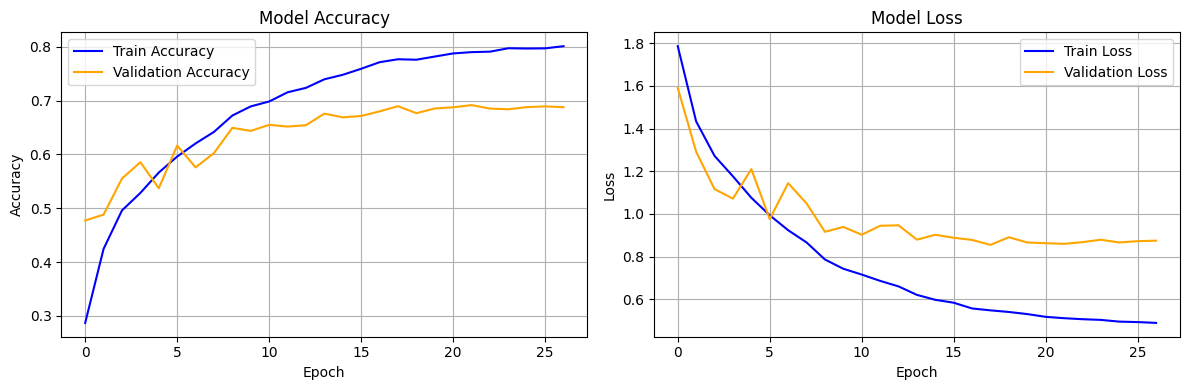

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
fer13_model.save_weights('fer13_weights.weights.h5')

#uncomment this if the RAM hits the limit
#fer13_model.load_weights('fer13_weights.weights.h5')

# **5. Create and train the AffectNet model with customised FER13 weights**

In [ ]:
#creating and AffectNet model, this is going to be very similar to the FER13, except there is also an arousal outputs as well as expression output

input_tensor = Input(shape=(224, 224, 3))
#loading the VGG16 with no weights first
base_model_new = VGG16(include_top=False, weights=None, input_tensor=input_tensor)

for layer in base_model_new.layers:
    layer.trainable = False
for layer in base_model_new.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True

x = base_model_new.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)

exp_branch = Dense(128, activation='relu')(x)
exp_output = Dense(7, activation='softmax', name='exp_output')(exp_branch)

aro_branch = Dense(128, activation='elu')(x)
aro_output = Dense(1, activation='linear', name='aro_output')(aro_branch)

affectnet_model = Model(inputs=input_tensor, outputs=[exp_output, aro_output])

plot_model(
    affectnet_model,
    to_file='AffectNetmodel_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR'
)

Now the FER13 are loaded layer by layer onto the AffectNet model

In [ ]:
for layer in affectnet_model.layers:
    try:
        source_layer = fer13_model.get_layer(name=layer.name)
        if layer.get_weights() and source_layer.get_weights():
            shapes_match = True
            for w1, w2 in zip(layer.get_weights(), source_layer.get_weights()):
                if w1.shape != w2.shape:
                    shapes_match = False
                    break
            if shapes_match:
                layer.set_weights(source_layer.get_weights())
            else:
                print(f"Skipping {layer.name} due to shape mismatch")
    except Exception as e:
        print(f"Skipping {layer.name} due to error: {e}")


In [ ]:
# compile the affectNet model with the allocated FER13 weights
affectnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss={
        'exp_output': 'sparse_categorical_crossentropy',
        'aro_output': 'mse'
    },
    #assigning loss weights to force the model to prioritise the arousal output due to easier learning of the emotion expression
    loss_weights={
        'exp_output': 0.3,
        'aro_output': 1.0
    },
    metrics={
        'exp_output': 'accuracy',
        'aro_output': 'mae'
    }
)
affectnet_model.summary()

In [ ]:
#uncomment if needed
'''affNet_images_train = 'AffectNet/affnet_images_train.npy'
affNet_exp_labels_train = 'AffectNet/affnet_exp_train.npy'
affNet_aro_labels_train = 'AffectNet/affnet_aro_train.npy'
affNet_images_val = 'AffectNet/affnet_images_val.npy'
affNet_exp_labels_val = 'AffectNet/affnet_exp_val.npy'
affNet_aro_labels_val = 'AffectNet/affnet_aro_val.npy' '''

#using similar callbacks as FER13, however we are now monitoring validation expression output accuracy
callbacks = [
    EarlyStopping(
        monitor='val_exp_output_accuracy',
        mode='max',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_exp_output_accuracy',
        mode='max',
        factor=0.5,
        patience=2,
        verbose=1
    )
]

history = affectnet_model.fit(
    x=affNet_images_train,
    y=[affNet_exp_labels_train, affNet_aro_labels_train],
    validation_data=(affNet_images_val, [affNet_exp_labels_val, affNet_aro_labels_val]),
    batch_size=32,
    epochs=40,
    callbacks=callbacks
)

affectnet_model.save('affectNet_model.keras')

Now we plot the model's performance to determine the effectiveness of learning and if the model is showing significant overfitting.

In [ ]:
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, hist['exp_output_loss'], label='Train Exp Loss')
    plt.plot(epochs, hist['val_exp_output_loss'], label='Val Exp Loss')
    plt.plot(epochs, hist['aro_output_loss'], label='Train Aro Loss')
    plt.title('Output Loss per Task')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, hist['exp_output_accuracy'], label='Train Exp Accuracy')
    plt.plot(epochs, hist['val_exp_output_accuracy'], label='Val Exp Accuracy')
    plt.title('Expression Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, hist['aro_output_mae'], label='Train ARO MAE')
    plt.axhline(y=baseline_aro_mae, color='purple', linestyle='--', label=f'Baseline Aro MAE ({baseline_aro_mae})')
    plt.title('Arousal MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [ ]:
#uncomment if needed
#affectnet_model = load_model('affectNet_model.keras')

Calculating the Baseline MAE to have a measure of how well the model is learning.

In [ ]:
baseline_aro = np.mean(affNet_aro_labels_train)
baseline_aro_mae = np.mean(np.abs(affNet_aro_labels_val - baseline_aro))

print("Baseline Arousal MAE:", baseline_aro_mae)

# **6. Apply the model's learnings to the test datasets - American and European**

In [ ]:
#uncomment if needed
'''famed_images_np = 'FAMED/famed_images.npy'
pedfe_images_np = 'PEDFE/pedfe_images.npy'
wsefep_images_np = 'WSEFEP/wsefep_images.npy'
disfa_images_np = 'DISFA/difsa_images.npy'
affNet_images_val = 'AffectNet/affnet_images_val.npy'
famed_exp_labels = 'FAMED/famed_exp_labels.npy'
pedfe_exp_labels = 'PEDFE/pedfe_exp_labels.npy'
wsefep_exp_labels = 'WSEFEP/wsefep_exp_labels.npy'
disfa_exp_labels = 'DISFA/difsa_exp_labels.npy'
affNet_exp_labels_val = 'AffectNet/affnet_exp_val.npy'
disfa_aro_labels = 'DISFA/difsa_aro_labels.npy'
wsefep_aro_labels = 'WSEFEP/wsefep_aro_labels.npy' '''

# generate predictions using the trained model
affectnet_preds = affectnet_model.predict(affNet_images_val)
famed_preds = affectnet_model.predict(famed_images_np)
pedfe_preds = affectnet_model.predict(pedfe_images_np)
wsefep_preds = affectnet_model.predict(wsefep_images_np)
disfa_preds = affectnet_model.predict(disfa_images_np)

#using the above predictions we can now predict the expressions
def get_predicted_classes(preds, ignore_last=False):
    exp_probs = preds[0]
    if ignore_last==True:
        exp_probs = exp_probs[:, :6]
    return np.argmax(exp_probs, axis=1)

# divide the overall predictions into expression class predictions, ignoring the last class for all except affectnet (has 7 classes, rest have 6)
affectnet_pred_classes = get_predicted_classes(affectnet_preds, ignore_last=False)
famed_pred_classes = get_predicted_classes(famed_preds, ignore_last=True)
pedfe_pred_classes = get_predicted_classes(pedfe_preds, ignore_last=True)
wsefep_pred_classes = get_predicted_classes(wsefep_preds, ignore_last=True)
disfa_pred_classes = get_predicted_classes(disfa_preds, ignore_last=True)

#print the accuracy score to 4 decimal points
print("AFFECTNET Accuracy:", f"{accuracy_score(affNet_exp_labels_val, affectnet_pred_classes):.4f}")
print("FAMED Accuracy:", f"{accuracy_score(famed_exp_labels, famed_pred_classes):.4f}")
print("PEDFE Accuracy:", f"{accuracy_score(pedfe_exp_labels, pedfe_pred_classes):.4f}")
print("WSEFEP Accuracy:", f"{accuracy_score(wsefep_exp_labels, wsefep_pred_classes):.4f}")
print("DISFA Accuracy:", f"{accuracy_score(disfa_exp_labels, disfa_pred_classes):.4f}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
AFFECTNET Accuracy: 0.5647
FAMED Accuracy: 0.2660
PEDFE Accuracy: 0.4813
WSEFEP Accuracy: 0.4056
DISFA Accuracy: 0.2326


The next step in analysing the results is to look at the Confusion Matrices.

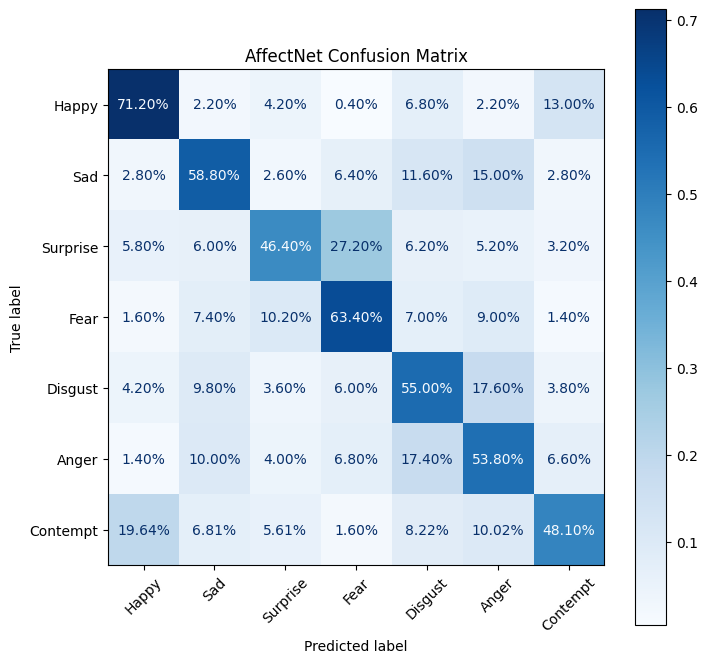

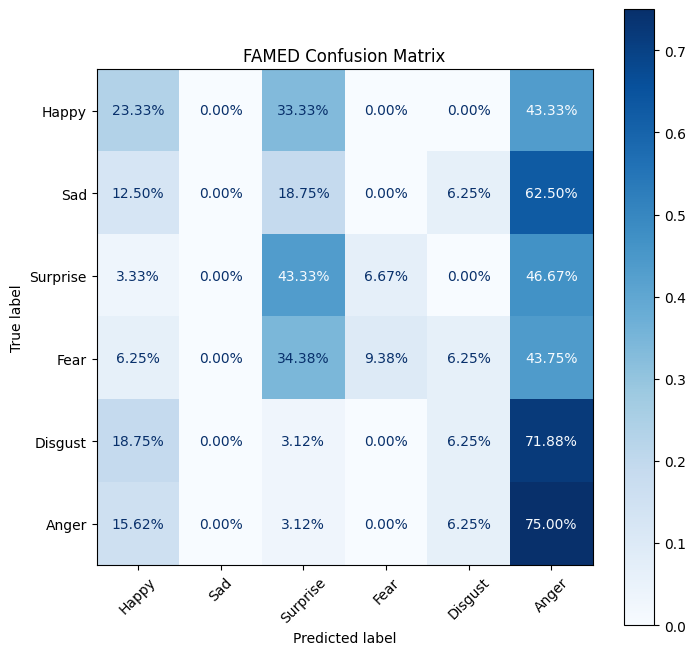

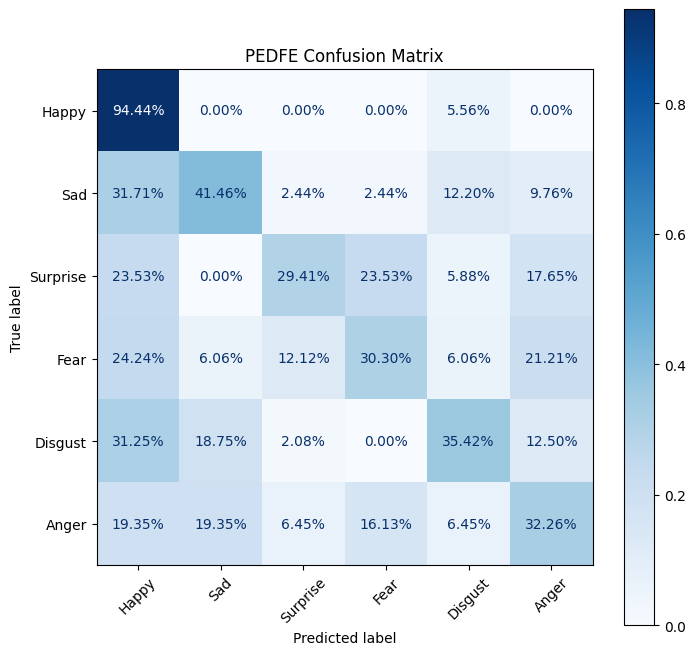

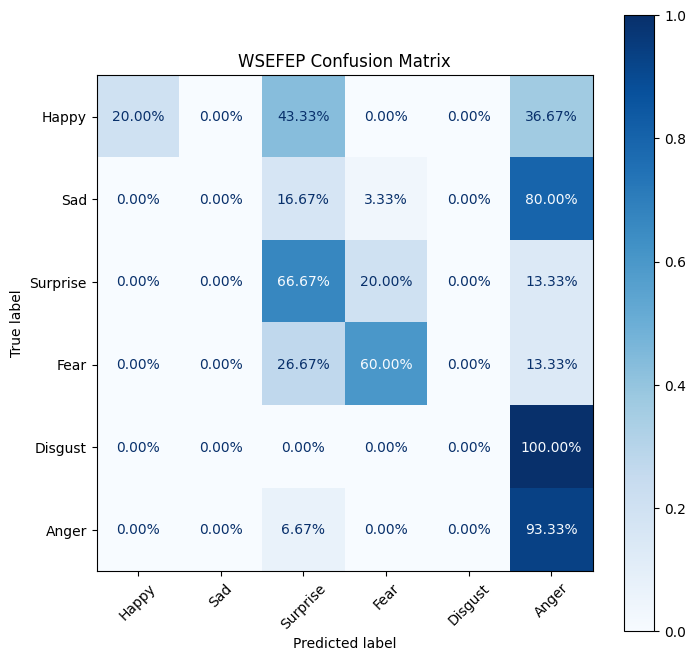

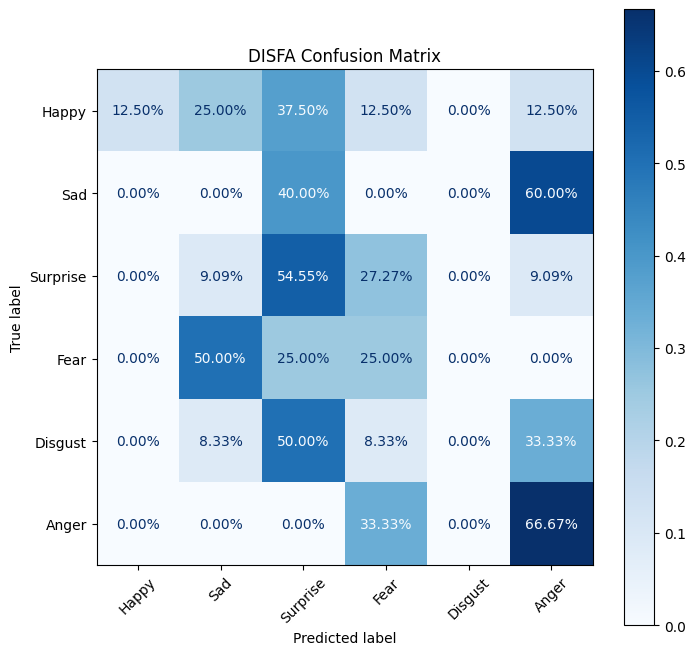

In [ ]:
#because AffectNet has an extra 7th class, it has to have its own class mapping
class_mapping_affectNet = {
    0: "Happy",
    1: "Sad",
    2: "Surprise",
    3: "Fear",
    4: "Disgust",
    5: "Anger",
    6: "Contempt"
}

def show_conf_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax, values_format='.2%')
    plt.title(title)
    plt.show()

show_conf_matrix(affNet_exp_labels_val, affectnet_pred_classes, "AffectNet Confusion Matrix", list(class_mapping_affectNet.values()))
show_conf_matrix(famed_exp_labels, famed_pred_classes, "FAMED Confusion Matrix", list(class_mapping.values()))
show_conf_matrix(pedfe_exp_labels, pedfe_pred_classes, "PEDFE Confusion Matrix", list(class_mapping.values()))
show_conf_matrix(wsefep_exp_labels, wsefep_pred_classes, "WSEFEP Confusion Matrix", list(class_mapping.values()))
show_conf_matrix(disfa_exp_labels, disfa_pred_classes, "DISFA Confusion Matrix", list(class_mapping.values()))

Because we can have a look at MAEs for DISFA and WSEFEP emotion intensities, this will help us to further understand the validity of the model. However, we need to scale the DISFA intensitites first, to make sure they match with the AffectNet arousal scale (and WSEFEP already matches).

In [ ]:
#assign the arousal predeictions
disfa_pred_aro = disfa_preds[1]
wsefep_pred_aro = wsefep_preds[1]
pedfe_pred_aro = pedfe_preds[1]
famed_pred_aro = famed_preds[1]
affectnet_pred_aro = affectnet_preds[1]

#convert the DISFA emotion intensity into the AffectNet arousal scale
disfa_true_aro = disfa_aro_labels / 5

disfa_mae = mean_absolute_error(disfa_true_aro, disfa_pred_aro)
wsefep_mae = mean_absolute_error(wsefep_aro_labels, wsefep_pred_aro)

print("DISFA MAE:", disfa_mae)
print("WSEFEP MAE:", wsefep_mae)


DISFA MAE: 0.30237817764282227
WSEFEP MAE: 0.11417119950056076


Now we plot the average arousal values to see whether the model saw a difference between cultures.

(0.0, 1.0)

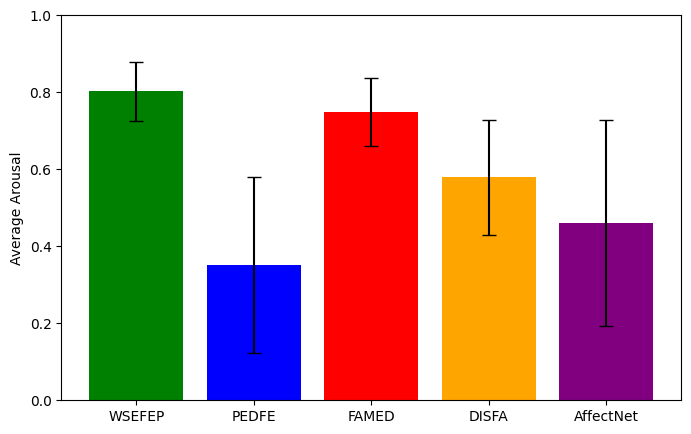

In [ ]:
avg_disfa = trim_mean(disfa_pred_aro.flatten(), 0.05)
avg_wsefep = trim_mean(wsefep_pred_aro.flatten(), 0.05)
avg_famed = trim_mean(famed_pred_aro.flatten(), 0.05)
avg_pedfe = trim_mean(pedfe_pred_aro.flatten(), 0.05)
avg_affectnet = trim_mean(affectnet_pred_aro.flatten(), 0.05)

datasets = ["WSEFEP", "PEDFE", "FAMED", "DISFA", "AffectNet"]
avg_values = [avg_wsefep, avg_pedfe, avg_famed, avg_disfa, avg_affectnet]
std_values = [
    np.std(wsefep_preds[1].flatten()),
    np.std(pedfe_preds[1].flatten()),
    np.std(famed_preds[1].flatten()),
    np.std(disfa_preds[1].flatten()),
    np.std(affectnet_preds[1].flatten())
]

plt.figure(figsize=(8, 5))
plt.bar(datasets, avg_values, yerr=std_values, capsize=5, color=['green', 'blue', 'red', 'orange', 'purple'])
plt.ylabel("Average Arousal")
plt.ylim(0, 1)
plt.show()

To access the results for the third hypothesis, we calculate average arousal per call for each dataset to explore the patterns further.

In [ ]:
def avg_arousal_per_class(name,labels, aro_preds):
    aro_by_class = {}
    for label, aro_score in zip(labels, aro_preds):
        if label not in aro_by_class:
            aro_by_class[label] = []
        aro_by_class[label].append(aro_score)
    results = {}
    print(name)
    for label, scores in aro_by_class.items():
        results[label] = np.mean(scores)
        print(f"{label}: {results[label]:.4f}")
    print('\n')


avg_disfa = avg_arousal_per_class("DISFA",disfa_exp_labels, disfa_pred_aro.flatten())
avg_wsefep = avg_arousal_per_class("WSEFEP",wsefep_exp_labels, wsefep_pred_aro.flatten())
avg_pedfe = avg_arousal_per_class("PEDFE",pedfe_exp_labels, pedfe_pred_aro.flatten())
avg_famed = avg_arousal_per_class("FAMED",famed_exp_labels, famed_pred_aro.flatten())
avg_affectnet = avg_arousal_per_class("AffectNet",affNet_exp_labels_val, affectnet_pred_aro.flatten())


DISFA
2: 0.6465
0: 0.5019
3: 0.5542
4: 0.5752
1: 0.6245
5: 0.5179


WSEFEP
0: 0.7325
4: 0.8116
2: 0.8260
3: 0.8314
1: 0.7771
5: 0.8145


PEDFE
3: 0.5317
5: 0.3718
0: 0.2478
1: 0.2391
2: 0.5305
4: 0.3056


FAMED
0: 0.7130
5: 0.7309
1: 0.7207
2: 0.7828
4: 0.7264
3: 0.7862


AffectNet
3: 0.6716
1: 0.1894
4: 0.4722
5: 0.5062
6: 0.4107
0: 0.2918
2: 0.6391




One final calculation we are going to perform is on the posed subsection of the PEDFE dataset - this is going to help understand the difference in predictions and accuracy scores between the posed and the spontaneus emotional reactions.

In [ ]:
pedfe_posed_images_path = 'PEDFE/Posed_images'
pedfe_posed_annotations = 'PEDFE/pedfe_posed_annot.csv'

pedfe_posed_labels = Labels()
pedfe_posed_labels.save_labels(pedfe_posed_annotations)
pedfe_posed_image_ids, pedfe_posed_exp_labels = pedfe_posed_labels.get_labels()

pedfe_posed_images = Dataset()
pedfe_posed_images_np = pedfe_posed_images.save_and_rescale_images(pedfe_posed_images_path, pedfe_posed_image_ids, notSquare=False)
np.save('PEDFE/pedfe_posed_images.npy', pedfe_posed_images_np)
np.save('PEDFE/pedfe_posed_exp_labels.npy', pedfe_posed_exp_labels)

pedfe_posed_preds = affectnet_model.predict(pedfe_posed_images_np)
pedfe_posed_pred_classes = get_predicted_classes(pedfe_posed_preds, ignore_last=True)
print("PEDFE Posed Accuracy:", f"{accuracy_score(pedfe_posed_exp_labels, pedfe_posed_pred_classes):.4f}")

avg_pedfe_posed = avg_arousal_per_class("PEDFE Posed",pedfe_posed_exp_labels, pedfe_posed_preds[1].flatten())

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
PEDFE Posed Accuracy: 0.5714
PEDFE Posed
5: 0.3298
4: 0.3314
3: 0.6919
0: 0.2241
1: 0.1764
2: 0.7184




***End of Code***